# Image segmentation with a U-Net model

## Imports and Project infos

In [2]:
#Only in case you run the project on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Path to the project and the dataset
#project_path = '/content/drive/MyDrive/Uni/HDA/Project' # Used to train in Colab
project_path = ''                                        # Used to train locally

model_name = 'segmentation_model'

train_input_path = os.path.join(project_path, 'datasets/boneage-train-dataset-preprocessed-1')
train_target_path = os.path.join(project_path, 'datasets/annotations/annotations_500_v2_train')
val_input_path = os.path.join(project_path, 'datasets/boneage-val-dataset-preprocessed-1')
val_target_path = os.path.join(project_path, 'datasets/annotations/annotations_500_v2_val')

model_file = os.path.join(project_path, f'models/{model_name}.h5')
log_file = os.path.join(project_path, f'logs/{model_name}-log.csv')

img_size = (512, 512)
label_size = (512, 512)
num_classes = 1

## Datasets and helper functions

In [6]:
def read_images(images_path):
    # Reads the image from the image path and normalize
    image = tf.io.read_file(images_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image

def create_dataset(input_path, label_path, batch_size=8, train=False):
    # Reads input images file names
    input_files = os.path.join(input_path, '*.png')
    label_files = os.path.join(label_path, '*.png')
    input_dataset = tf.data.Dataset.list_files(input_files, shuffle=False)
    label_dataset = tf.data.Dataset.list_files(label_files, shuffle=False)
    
    # Reads the images
    input_dataset = input_dataset.map(lambda input_image_path: read_images(input_image_path), num_parallel_calls=tf.data.AUTOTUNE)
    label_dataset = label_dataset.map(lambda label_image_path: read_images(label_image_path), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = tf.data.Dataset.zip((input_dataset, label_dataset))
    
    # Shuffle
    if train:
        dataset = dataset.shuffle(len(dataset))
        
    # Batch
    dataset = dataset.batch(batch_size=batch_size)
    
    # Cache the dataset
    dataset = dataset.cache()
    
    # Prefetch
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

def split_dataset(dataset, test_split=0.2):
    dataset_size = len(dataset)
    
    train_size = int((1 - test_split) * dataset_size)
    test_size = int(test_split * dataset_size)
    
    train_dataset = dataset.take(train_size).cache()
    val_dataset = dataset.skip(train_size).take(test_size).cache()
    
    return train_dataset, val_dataset

def show_image(image):
    plt.figure()
    plt.imshow(image[:, :, 0], cmap='gray')
    
def get_images_from_dataset(dataset, index=None):
    inputs, labels = next(dataset.as_numpy_iterator())
    
    if index is None:
        return inputs, labels
    else:
        return inputs[index], labels[index]

In [9]:
train_dataset = create_dataset(train_input_path, train_target_path, train=True)
val_dataset = create_dataset(val_input_path, val_target_path, train=False)

## Model definition

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

model = build_unet(input_shape=(512, 512, 1), n_classes=1)
#print(model.summary())

2022-02-08 15:14:56.741740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-08 15:14:56.742079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


## Train the model

In [ ]:
MeanIoU = tf.keras.metrics.MeanIoU(num_classes=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-02)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[MeanIoU])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_file, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.8, patience=20, cooldown=10),
    tf.keras.callbacks.CSVLogger(log_file, append=True)
]

epochs = 2000
model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/2000
50/50 [==============================] - 127s 2s/step - loss: 0.3938 - mean_io_u: 0.4044 - val_loss: 1002.3516 - val_mean_io_u: 0.0984 - lr: 0.0100
Epoch 2/2000
50/50 [==============================] - 37s 705ms/step - loss: 0.3409 - mean_io_u: 0.4044 - val_loss: 0.4550 - val_mean_io_u: 0.4116 - lr: 0.0100
Epoch 3/2000
50/50 [==============================] - 33s 624ms/step - loss: 0.3364 - mean_io_u: 0.4044 - val_loss: 2.5011 - val_mean_io_u: 0.4144 - lr: 0.0100
Epoch 4/2000
50/50 [==============================] - 33s 625ms/step - loss: 0.3042 - mean_io_u: 0.4044 - val_loss: 1.5307 - val_mean_io_u: 0.4116 - lr: 0.0100
Epoch 5/2000
50/50 [==============================] - 33s 626ms/step - loss: 0.2173 - mean_io_u: 0.4044 - val_loss: 1.3684 - val_mean_io_u: 0.4116 - lr: 0.0100
Epoch 6/2000
50/50 [==============================] - 33s 626ms/step - loss: 0.1280 - mean_io_u: 0.4044 - val_loss: 0.8554 - val_mean_io_u: 0.4132 - lr: 0.0100
Epoch 7/2000
50/50 [===================

## Visualize predictions

In [ ]:
model = tf.keras.models.load_model(model_file)

In [ ]:
val_predictions = model.predict(val_dataset)

In [ ]:
index = 0

input_image, label_image = get_images_from_dataset(val_dataset, index)
    
show_image(input_image)
show_image(label_image)

pred = val_predictions[index]
image = pred > 0.10
show_image(image)

## Segment

In [15]:
model = tf.keras.models.load_model(model_file)

In [58]:
def segment_dataset(input_dataset_path, output_dataset_path, debug=False, debug_idx=0):
    images_path = os.listdir(input_dataset_path)
    images_size = len(images_path)
    
    for idx, file_name in enumerate(images_path):
        if idx != debug_idx:
            continue
        if not debug:
            print(f'\r{((idx+1)/images_size*100):.2f}%', end='')
        
        file_path = input_dataset_path + '/' + file_name
        input_image = plt.imread(file_path, format='png')
        input_image = np.expand_dims(input_image, axis=0)

        pred_mask = model.predict(input_image)[0]
        
        input_image = input_image[0, :, :]
        pred_mask = (pred_mask > 0.10)[:, :, 0]

        output_image = np.full(shape=(512, 512), fill_value=0.0)
        output_image[pred_mask] = input_image[pred_mask]

        image_name = f'{output_dataset_path}/{file_name}'
        
        if debug:
            # Original image
            plt.figure()
            plt.imshow(input_image, cmap='gray')
            plt.xticks([])
            plt.yticks([])
            
            # Predicted mask
            plt.figure()
            plt.imshow(pred_mask, cmap='gray')
            plt.xticks([])
            plt.yticks([])
        
            # Cleaned image
            plt.figure()
            plt.imshow(output_image, cmap='gray', vmin=0.0, vmax=1.0)
            plt.xticks([])
            plt.yticks([])
            
            break
        else:
            plt.imsave(image_name, output_image, cmap='gray')

In [21]:
input_train_dataset_path = os.path.join(project_path, 'datasets/boneage-train-dataset-preprocessed-1')
output_train_dataset_path = os.path.join(project_path, 'datasets/boneage-train-dataset-preprocessed-2')
input_val_dataset_path = os.path.join(project_path, 'datasets/boneage-val-dataset-preprocessed-1')
output_val_dataset_path = os.path.join(project_path, 'datasets/boneage-val-dataset-preprocessed-2')
input_test_dataset_path = os.path.join(project_path, 'datasets/boneage-test-dataset-preprocessed-1')
output_test_dataset_path = os.path.join(project_path, 'datasets/boneage-test-dataset-preprocessed-2')

In [71]:
segment_dataset(input_train_dataset_path, output_train_dataset_path)

100.00%

In [73]:
segment_dataset(input_val_dataset_path, output_val_dataset_path)

100.00%

In [74]:
segment_dataset(input_test_dataset_path, output_test_dataset_path)

100.00%

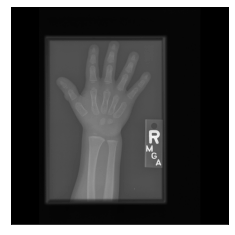

In [59]:
segment_dataset(input_test_dataset_path, output_test_dataset_path, debug=True, debug_idx=1)